In [144]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
from db_load import *
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

from scipy import stats

In [119]:
client = get_client()
ad_vs_ent, ad_vs_ent_dist, degree_dist, coredb, balancesdb, sccdb = get_gold_collections(client)

In [129]:
advsent = [i for i in ad_vs_ent.find({})]
advsent_dist = [i for i in ad_vs_ent_dist.find({})]
degreedist = [i for i in degree_dist.find({})]
core = [i for i in coredb.find({})]
balances = [i for i in balancesdb.find({})]
scc = [i for i in sccdb.find({})]

all_arr = [advsent, advsent_dist, degreedist, core, balances, scc]

In [48]:
curr_date = datetime.fromtimestamp(advsent[-1]["timestamp"])
timestamps = []

for i in range(6):
    curr_date += relativedelta(months=4)  
    timestamps.append(int(datetime.timestamp(curr_date)))
    print("ts ", int(datetime.timestamp(curr_date)), " date ", curr_date)

ts  1616539491  date  2021-03-23 23:44:51
ts  1627076691  date  2021-07-23 23:44:51
ts  1637707491  date  2021-11-23 23:44:51
ts  1648075491  date  2022-03-23 23:44:51
ts  1658612691  date  2022-07-23 23:44:51
ts  1669243491  date  2022-11-23 23:44:51


## Addresses and Entities

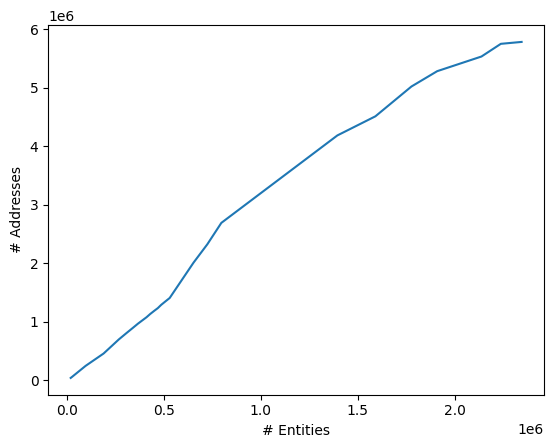

In [110]:
x = [i["no_ent"] for i in advsent]
y = [i["no_addr"] for i in advsent]

plt.plot(x, y)
plt.ylabel("# Addresses")
plt.xlabel("# Entities")
plt.show()

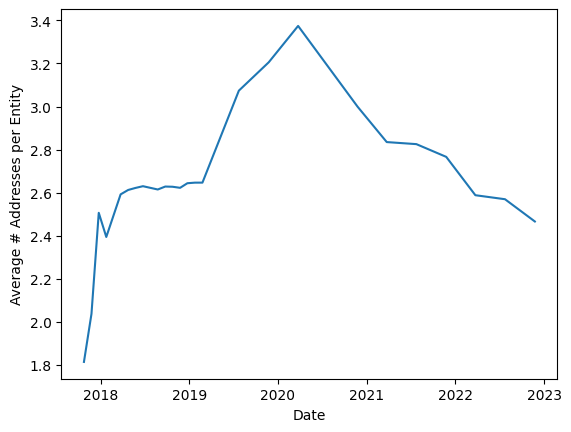

In [113]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in advsent]
y = [i["no_addr"]/i["no_ent"] for i in advsent]

plt.plot(xdate, y)
plt.xlabel("Date")
plt.ylabel("Average # Addresses per Entity")
plt.show()

## core perihpery

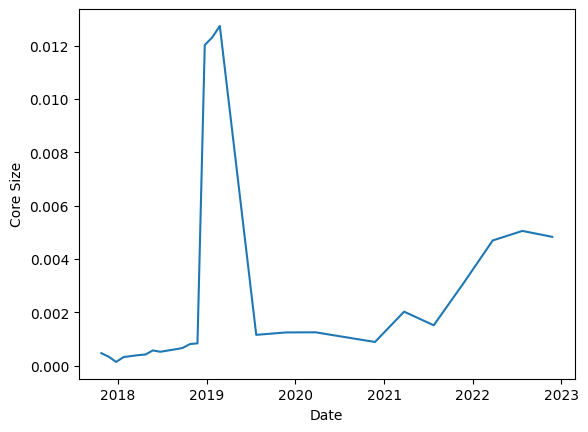

In [121]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in core]
coresize = np.array([i["core_length"] for i in core] )
ents = np.array([i["no_ent"] for i in advsent])

plt.plot(xdate, coresize/ents)
plt.xlabel("Date")
plt.ylabel("Core Size")
plt.show()

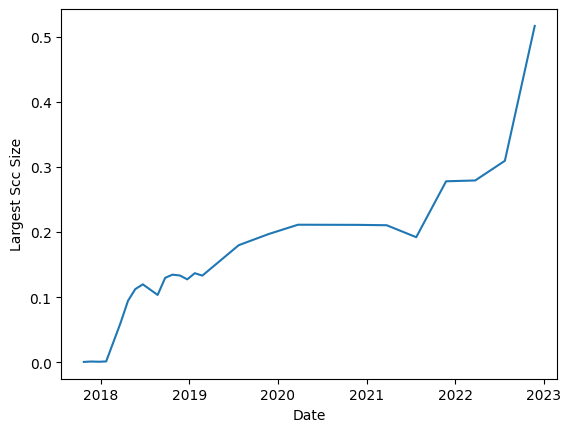

In [130]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in scc]
sccs = np.array([i["scc_size"] for i in scc] )
ents = np.array([i["no_ent"] for i in advsent])

plt.plot(xdate, sccs/ents)
plt.xlabel("Date")
plt.ylabel("Largest Scc Size")
plt.show()

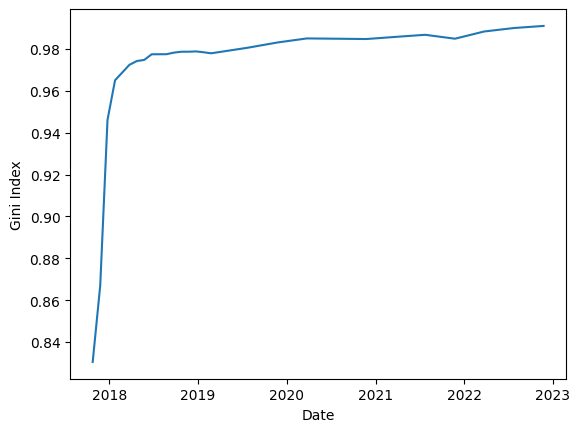

In [123]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in balances]
y = np.array([i["gini_index"] for i in balances] )

plt.plot(xdate, y)
plt.xlabel("Date")
plt.ylabel("Gini Index")
plt.show()


In [168]:
def return_arr(d):
    res = []
    for k, v in d.items():
        res.extend([int(k)] * int(v))
    return res


alphas = []
passing_test = []
dis = []

for e, i in enumerate(degreedist):
    print(e)
    d = return_arr(i["ditribution_total"])
    shape_param, loc_param, scale_param = stats.pareto.fit(d)
    alphas.append(shape_param)
    s, pvalue =  stats.kstest(d, "pareto", args=stats.pareto.fit(d))
    passing_test.append(pvalue>=0)
    dis.append(s)



0


/home/ubuntu/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [170]:
dis2 = []
for e, i in enumerate(degreedist):
    print(e)
    d = return_arr(i["ditribution_total"])

    s, pvalue =  stats.kstest(d, "binom")
    dis2.append(s)

0


TypeError: _parse_args() missing 2 required positional arguments: 'n' and 'p'

In [169]:
print("minimum: ", min(alphas))
print("maximum: ", max(alphas))
print("1st quartile: ", np.percentile(alphas, 25))
print("1st quartile: ", np.percentile(alphas, 75))
print("median: ", np.median(alphas))

print("distance average: ", np.median(dis))

minimum:  0.2741773309660037
maximum:  2.0589588682001096
1st quartile:  0.9357342399309039
1st quartile:  1.2575296402441483
median:  1.042318609790152
distance average:  0.32615227991707085


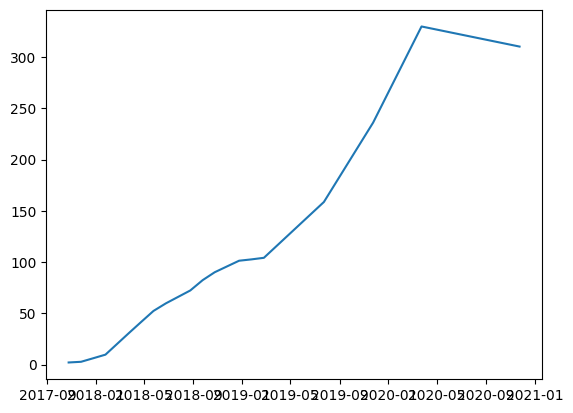

In [172]:
x = []
y = []
for i in degreedist:
    x.append(datetime.fromtimestamp(i["timestamp"]))
    d = return_arr(i["ditribution_total"])
    y.append(np.average(d))

plt.plot(x, y)


## Gini Index

# Plot Data

### Average address per entity number

## Wealth distribution
### Gini Index 

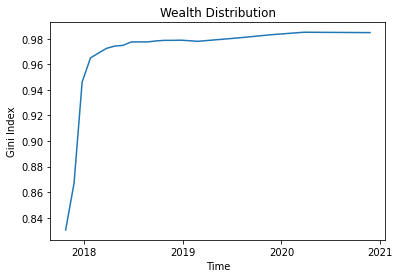

In [22]:
# Create wealth distribution plot
wealth_dist = [b for b in balances.find({})]

x = [datetime.fromtimestamp(b["timestamp"]) for b in wealth_dist]
y1 = [b["gini_index"] for b in wealth_dist]
y2 = [b["gini_index_no_zeros"] for b in wealth_dist]


get_plot(x, y1, "Full Data", "Time", "Gini Index", "Wealth Distribution", xtime=True)


### Average Wealth

[1044558487848.0641, 855153401588.2426, 249134968652.75436, 123949233089.30524, 85680815213.23837, 72585115023.31256, 62726752926.67522, 58762602506.830215, 50375748862.78445, 44592416747.776146, 42191994236.33078, 40446963677.28099, 38302167003.45451, 36247999560.91123, 34574757937.45633, 29982751758.392933, 25251741539.61282, 22879097505.442528, 18776777013.151443]


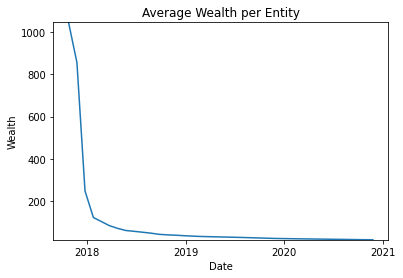

In [41]:
y3 = [b["average_wealth"] for b in wealth_dist]

fig, ax = plt.subplots(1,1)
years = mdates.YearLocator()   # every 1 year
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)

y3 = np.array(y3)/10**9
ax.plot(x, y3)
ax.set_xlabel("Date")
ax.set_ylabel("Amount of ADA in ")
ax.set_title("Average Wealth per Entity")
plt.show()